In [1]:
# create table tt_q_tag_cnt as 
# select x.id
# 	, to_char(x.creationdate, 'yyyy-mm-dd') as c_date
# 	, (regexp_matches(x.tags, '<(ruby|scala|rust|go|bash|shell|objective-c|python|r|typescript|swift|c#|sql|assembly|kotlin|c\+\+|javascript|vba|c|html|css|java|perl|haskell|julia|php|dart|clojure|f#|elixir|erlang|lisp|groovy|crystal-lang|powershell|cobol|delphi|matlab)>', 'g'))[1] AS matched_tags
# 	, x.tag
#   from (
# 	select id, creationdate, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag 
#   from posts
# where posttypeid ='1'
#   and (tags like '%<ruby>%' or tags like '%<scala>%' or tags like '%<rust>%' or tags like '%<go>%' or tags like '%<bash>%' or tags like '%<shell>%' or tags like '%<objective-c>%' or tags like '%<python>%' or tags like '%<r>%' or tags like '%<typescript>%' or tags like '%<swift>%' or tags like '%<c#>%' or tags like '%<sql>%' or tags like '%<assembly>%' or tags like '%<kotlin>%' or tags like '%<c++>%' or tags like '%<javascript>%' or tags like '%<vba>%' or tags like '%<c>%' or tags like '%<html>%' or tags like '%<css>%' or tags like '%<java>%' or tags like '%<perl>%' or tags like '%<haskell>%' or tags like '%<julia>%' or tags like '%<php>%' or tags like '%<dart>%' or tags like '%<clojure>%' or tags like '%<f#>%' or tags like '%<elixir>%' or tags like '%<erlang>%' or tags like '%<lisp>%' or tags like '%<groovy>%' or tags like '%<crystal-lang>%' or tags like '%<powershell>%' or tags like '%<cobol>%' or tags like '%<delphi>%' or tags like '%<matlab>%')
#   and creationdate between '2021-11-30' and '2023-12-03' 
#   ) x 
# ;

In [2]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
ppp = os.path.abspath('../../visualization')

sys.path.insert(1, p)
sys.path.insert(1, pp)
sys.path.insert(1, ppp)



In [3]:
import json
import pandas as pd
import numpy as np
from utils.salary import *
import psycopg2
from utils.statistics import *
import config.config as conf
import datetime
import re
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import matplotlib.pyplot as plt
colors = plt.get_cmap('tab20').colors 

## 데이터전처리

In [4]:
output_dir = '../fig/'
by = 'rel_week'

In [5]:
# test.json 내용: [{"name":"Jack","age":26},{"name":"Ace","age":87}]
df = pd.read_json('../../visualization/result/tag/salary.json') ## pd.read_json 이용

In [6]:
df = df.reset_index().rename(columns={'index':'year'})

In [7]:
df = df.sort_values(by = 'year').reset_index(drop=True)

In [8]:
df

,year,clojure,f#,elixir,erlang,perl,ruby,scala,rust,go,...,zig,apex,nim-lang,raku,ada,prolog,gdscript,vb.net,micropython,zephyr-rtos
0,2019,90000.0,80000.0,76000.0,71000.0,NaN,75000,78000,72000,80000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,NaN,NaN,NaN,76000.0,71000,76000,74000,74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,95000.0,81037.0,80077.0,80077.0,80000.0,80000,77832,77530,75669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,106644.0,95526.0,92959.0,103000.0,90073.0,93000,92780,87047,89204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,96381.0,99311.0,96381.0,99492.0,94540.0,98522,96381,87012,92760,...,103611.0,81552.0,80000.0,79448.0,71500.0,70000.0,69608.0,65000.0,NaN,NaN
5,2024,95541.0,80555.0,96000.0,100636.0,90000.0,90221,88619,76292,76433,...,75332.0,82500.0,94924.0,NaN,42584.0,43327.0,60684.0,63694.0,75184.0,64444.0


In [9]:
def get_CID_ratio_df(df, year) : 
    year_list = [year-3, year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    filtered_df = df_salary[df_salary['lang'].isin(df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index)].copy()
    filtered_df['salary_ratio'] = filtered_df.groupby(['lang'])['salary'].transform(lambda x: x/x.shift(1) )
    filtered_df = filtered_df.dropna()

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['salary_ratio'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['CID'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)


    return filtered_df




In [10]:
def get_CID_df(df, year) : 
    year_list = [year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    filtered_df = df_salary[df_salary['lang'].isin(df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index)].copy()
    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['salary'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['CID'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)


    return filtered_df




In [11]:
def get_CID_log_df(df, year) : 
    year_list = [year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()
    df_salary['salary'] = np.log(df_salary['salary'])

    filtered_df = df_salary[df_salary['lang'].isin(df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index)].copy()
    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['salary'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['CID'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)


    return filtered_df




In [61]:
def get_CID_ratio_rel_df(df, year) : 
    year_list = [year-3, year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    valid_langs = df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index
    filtered_df = df_salary[df_salary['lang'].isin(valid_langs)].copy()

    # 언어별로 연도 정렬 후 상대 변화율(성장률) 계산
    filtered_df.sort_values(by=['lang', 'year'], inplace=True)
    filtered_df['growth_rate'] = filtered_df.groupby('lang')['salary'].pct_change()

    # growth_rate의 이차 차분 = CID 계산
    filtered_df['CID'] = filtered_df.groupby('lang')['growth_rate'].diff()

    # 최종 정리: CID 계산이 가능한 연도만 남김
    filtered_df = filtered_df.dropna(subset=['growth_rate', 'CID']).reset_index(drop=True)


    return filtered_df




In [62]:
def filter_df( df, type ) :
    tot_filtered_df = pd.DataFrame()
    for year in [ 2022, 2023, 2024] : 
        if type == 'ratio' : 
            filtered_df = get_CID_ratio_df(df, year)
        elif type == 'log' : 
            filtered_df = get_CID_log_df(df, year)
        elif type == 'ratio_rel' :
            filtered_df = get_CID_ratio_rel_df(df, year)
            
        else :
            filtered_df = get_CID_df(df, year)
            
        tot_filtered_df = pd.concat([tot_filtered_df, filtered_df], axis = 0)
    
        tot_exist_df = tot_filtered_df[tot_filtered_df['lang'].isin(tot_filtered_df['lang'].value_counts()[lambda x: x == len([ 2022, 2023, 2024])].index)].copy()
        tot_exist_df=  tot_exist_df.sort_values(by = ['year', 'CID'], ascending=[False, True])
    return tot_exist_df

In [63]:
tot_df_r = filter_df(df, 'ratio')
tot_df_log = filter_df(df, 'log')
tot_df_nr = filter_df(df, 'notratio')
tot_df_rl = filter_df(df, 'ratio_rel')

[2019, 2020, 2021, 2022]
[2020, 2021, 2022, 2023]
[2021, 2022, 2023, 2024]
[2020, 2021, 2022]
[2021, 2022, 2023]
[2022, 2023, 2024]
[2020, 2021, 2022]
[2021, 2022, 2023]
[2022, 2023, 2024]
[2019, 2020, 2021, 2022]
[2020, 2021, 2022, 2023]
[2021, 2022, 2023, 2024]


In [65]:
tot_df_rl

,year,lang,salary,growth_rate,CID


In [14]:
cid_2024_lang = tot_df_r[tot_df_r['year'] == 2024].sort_values(by = ['CID'], ascending=[False])

In [15]:
cid_2024_df = tot_df_log[tot_df_log['lang'].isin(cid_2024_lang['lang'].values)]

In [16]:
cid_2024_df.head()
cid_2024 = cid_2024_df[cid_2024_df['year'] == 2024].sort_values(by = ['CID'], ascending=[False])

In [17]:
cid_2024

,year,lang,salary,CID
27,2024,vba,11.073552,-0.071930
6,2024,scala,11.392102,-0.122041
7,2024,rust,11.242323,-0.131076
5,2024,ruby,11.410017,-0.145698
12,2024,bash/shell,11.227694,-0.178476
21,2024,c#,11.098410,-0.201778
29,2024,html/css,11.026549,-0.223788
22,2024,sql,11.080896,-0.225178
8,2024,go,11.244170,-0.232691
17,2024,python,11.123181,-0.242303


## 데이터 로드

In [18]:
# conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
# try:
#     cur = conn.cursor()
#     cur.execute("\
# select c_date, matched_tags, tag, count(*) as cnt \
#   from tt_q_tag_cnt \
#  group by c_date, matched_tags, tag \
# ; \
#                 " 
#    )
#     rows = cur.fetchall()
    

# except psycopg2.DatabaseError as db_err:
#     print(db_err)
# finally : 
#   cur.close()

In [19]:
# conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
# try:
#     cur = conn.cursor()
#     cur.execute("\
# select c_date, matched_tags, tag, sum(prop_for_t) as cnt \
#   from tt_q_tag_cnt_02 \
#  group by c_date, matched_tags, tag \
# ; \
#                 " 
#    )
#     rows = cur.fetchall()
    

# except psycopg2.DatabaseError as db_err:
#     print(db_err)
# finally : 
#   cur.close()

In [20]:
str([x for x in cid_2024['lang']])[1:-1]

"'vba', 'scala', 'rust', 'ruby', 'bash/shell', 'c#', 'html/css', 'sql', 'go', 'python', 'swift', 'c++', 'typescript', 'r', 'c', 'assembly', 'javascript', 'objective-c', 'java', 'kotlin'"

In [21]:
q_string =  f"select c_date, matched_tags, tag, sum(prop_for_t) as cnt from tt_q_tag_cnt_02 where matched_tags in ({str([x for x in cid_2024['lang']])[1:-1]}) group by c_date, matched_tags, tag; "


In [22]:
q_string

"select c_date, matched_tags, tag, sum(prop_for_t) as cnt from tt_q_tag_cnt_02 where matched_tags in ('vba', 'scala', 'rust', 'ruby', 'bash/shell', 'c#', 'html/css', 'sql', 'go', 'python', 'swift', 'c++', 'typescript', 'r', 'c', 'assembly', 'javascript', 'objective-c', 'java', 'kotlin') group by c_date, matched_tags, tag; "

In [23]:
# CID를 다시 계산함에 따라 시각화에 사용할 언어 변경(2020년부터 2024년까지 모든 SALARY 데이터가 존재하는 언어를 대상으로 )
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute(q_string)
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [24]:
tag_dis_df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'matched_tags' 
, 'tag'
, 'cnt'
])

In [25]:
tag_dis_df.head()

,cdate,matched_tags,tag,cnt
0,2021-01-01,assembly,arm,0.50000000000000000000
1,2021-01-01,assembly,assembly,3.84999999999999999999
2,2021-01-01,assembly,c,0.78333333333333333333
3,2021-01-01,assembly,cpu-architecture,0.20000000000000000000
4,2021-01-01,assembly,cpu-registers,0.20000000000000000000


In [26]:
std_date = datetime.datetime(2022, 11, 30)

In [27]:
tag_dis_df['cdate'] = pd.to_datetime(tag_dis_df['cdate'], format="%Y-%m-%d")
tag_dis_df['rel_day'] = (tag_dis_df['cdate'] - std_date).dt.days
tag_dis_df['rel_week'] = np.floor(tag_dis_df['rel_day']/7)

In [28]:
tag_dis_df = tag_dis_df[(tag_dis_df['rel_week']>-53 ) & (tag_dis_df['rel_week']<=52 )]

In [29]:
tot_df = tag_dis_df.groupby([by, 'matched_tags'])['cnt'].sum().reset_index(name='tot_cnt')

In [30]:
tag_dis_by_df = tag_dis_df.groupby([by, 'matched_tags', 'tag'])['cnt'].sum().reset_index(name = 'cnt')

In [31]:
tag_dis_by_df.head()

,rel_week,matched_tags,tag,cnt
0,-52.0,assembly,6502,0.25000000000000000000
1,-52.0,assembly,68000,0.25000000000000000000
2,-52.0,assembly,8-bit,0.25000000000000000000
3,-52.0,assembly,8051,0.25000000000000000000
4,-52.0,assembly,addressing-mode,0.53333333333333333333


In [32]:
df_proportion = pd.merge(tag_dis_by_df, tot_df, on = [by, 'matched_tags'], how = 'left')
df_proportion['proportion'] = df_proportion['cnt'] / df_proportion['tot_cnt']
# .reset_index(name='count')

In [33]:
df_proportion.tail()

,rel_week,matched_tags,tag,cnt,tot_cnt,proportion
960465,52.0,vba,vb.net,0.33333333333333333333,97.99999999999999999974,0.003401360544217687074804942385
960466,52.0,vba,vba,40.06666666666666666658,97.99999999999999999974,0.4088435374149659863947581563
960467,52.0,vba,windows,0.91666666666666666666,97.99999999999999999974,0.009353741496598639455739101763
960468,52.0,vba,worksheet,0.33333333333333333333,97.99999999999999999974,0.003401360544217687074804942385
960469,52.0,vba,x-axis,0.20000000000000000000,97.99999999999999999974,0.002040816326530612244903373594


In [34]:
df_proportion['proportion'] = df_proportion['proportion'].astype(float)
df_proportion['tot_cnt'] = df_proportion['tot_cnt'].astype(float)

In [35]:
df_entropy = df_proportion.groupby([by, 'matched_tags'])['proportion'].apply(lambda x : calculate_entropy(x)).to_frame(name='entropy').reset_index()

In [36]:
df_entropy_viz = pd.merge(df_entropy, df_proportion[[by, 'matched_tags', 'tot_cnt']].drop_duplicates(), \
                           on = [by, 'matched_tags'], how = 'left')

In [37]:
df_proportion

,rel_week,matched_tags,tag,cnt,tot_cnt,proportion
0,-52.0,assembly,6502,0.25000000000000000000,66.0,0.003788
1,-52.0,assembly,68000,0.25000000000000000000,66.0,0.003788
2,-52.0,assembly,8-bit,0.25000000000000000000,66.0,0.003788
3,-52.0,assembly,8051,0.25000000000000000000,66.0,0.003788
4,-52.0,assembly,addressing-mode,0.53333333333333333333,66.0,0.008081
...,...,...,...,...,...,...
960465,52.0,vba,vb.net,0.33333333333333333333,98.0,0.003401
960466,52.0,vba,vba,40.06666666666666666658,98.0,0.408844
960467,52.0,vba,windows,0.91666666666666666666,98.0,0.009354
960468,52.0,vba,worksheet,0.33333333333333333333,98.0,0.003401


In [38]:
df_entropy_viz['log_tot_cnt'] = np.log(df_entropy_viz['tot_cnt'])

In [39]:
cid_2024

,year,lang,salary,CID
27,2024,vba,11.073552,-0.071930
6,2024,scala,11.392102,-0.122041
7,2024,rust,11.242323,-0.131076
5,2024,ruby,11.410017,-0.145698
12,2024,bash/shell,11.227694,-0.178476
21,2024,c#,11.098410,-0.201778
29,2024,html/css,11.026549,-0.223788
22,2024,sql,11.080896,-0.225178
8,2024,go,11.244170,-0.232691
17,2024,python,11.123181,-0.242303


In [40]:
lang_t5_2024 = list(cid_2024['lang'])[:5]
lang_b5_2024 = list(cid_2024['lang'])[-5:]

In [41]:
# lang_t5_2024.append('python')
# # lang_b5_2024.append('python')

In [42]:
df_entropy_viz_bf = df_entropy_viz[df_entropy_viz[by]<0]
df_entropy_viz_af = df_entropy_viz[df_entropy_viz[by]>=0]

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

def analyze_entropy_change(data, measure='entropy'):
    results = []

    languages = data['matched_tags'].unique()

    for lang in languages:
        df_lang = data[data['matched_tags'] == lang]
        before = df_lang[df_lang['rel_week'] < 0]['entropy']
        after  = df_lang[df_lang['rel_week'] >= 0]['entropy']
        

        if len(before) < 5 or len(after) < 5:
            continue  # 샘플 너무 적으면 스킵

        # 평균
        mean_before = before.mean()
        mean_after = after.mean()
        diff = mean_after - mean_before

        # 표준오차 (SE)와 95% 신뢰구간
        pooled_se = np.sqrt(before.var(ddof=1)/len(before) + after.var(ddof=1)/len(after))
        ci_low = diff - 1.96 * pooled_se
        ci_high = diff + 1.96 * pooled_se

        pval = mannwhitneyu(before, after, alternative='two-sided').pvalue

        results.append({
            'Language': lang,
            'Mean_Before': mean_before,
            'Mean_After': mean_after,
            'Diff': diff,
            'CI_Low': ci_low,
            'CI_High': ci_high,
            'pvalue': pval
        })

    summary_df = pd.DataFrame(results)
    return summary_df

In [44]:
import matplotlib.pyplot as plt

def plot_forest_with_significance(summary_df):
    summary_df = summary_df.sort_values('Diff')
    languages = summary_df['Language']
    diffs = summary_df['Diff']
    errors = [diffs - summary_df['CI_Low'], summary_df['CI_High'] - diffs]
    p_values = summary_df['pvalue']

    fig, ax = plt.subplots(figsize=(8, max(6, len(languages) * 0.3)))

        # 별표 추가
    significance = []
    for p in p_values:
        # if p < 0.001:
        #     significance.append('***')
        # elif p < 0.01:
        #     significance.append('**')
        if p < 0.05:
            significance.append('*')
        else:
            significance.append('')

    labels = [f"{lang} ({sig})" if sig else lang for lang, sig in zip(languages, significance)]
    
    ax.errorbar(diffs, labels, xerr=errors, fmt='o', color=colors[4], ecolor='lightgray', elinewidth=2, capsize=4)
    ax.axvline(0, color='black', linestyle='--')
    ax.set_title('Language-wise Entropy Change')
    ax.set_xlabel('Change in Entropy After ChatGPT')
    ax.grid(True, axis='x')

    
    for label in ax.get_yticklabels():
        original_text = label.get_text()        # 예: "python***"
        clean_text = original_text.replace('*', '').replace('(', '').replace(')', '').replace(' ', '')  # "python" 으로 비교
        # 여기서 highlight_labels는 "언어명"만 들어 있어야 해 (별표 없이)
        # 그래서 text에서 별표 제거한 후 비교
        print(clean_text)
        if clean_text in lang_t5_2024:
            label.set_text(original_text)
            label.set_color('red')  # 강조할 언어는 빨간색
            print(original_text)
        elif clean_text in lang_b5_2024:
            label.set_text(original_text)
            label.set_color('blue')  # 강조할 언어는 빨간색
        else:
            label.set_text(original_text)
            label.set_color('black')  # 나머지는 검정색

    plt.tight_layout()
    plt.show()


objective-c
assembly
ruby
ruby
swift
vba
vba (*)
java
go
scala
scala
sql
kotlin
c#
c++
r
c
typescript
javascript
rust
rust (*)
python


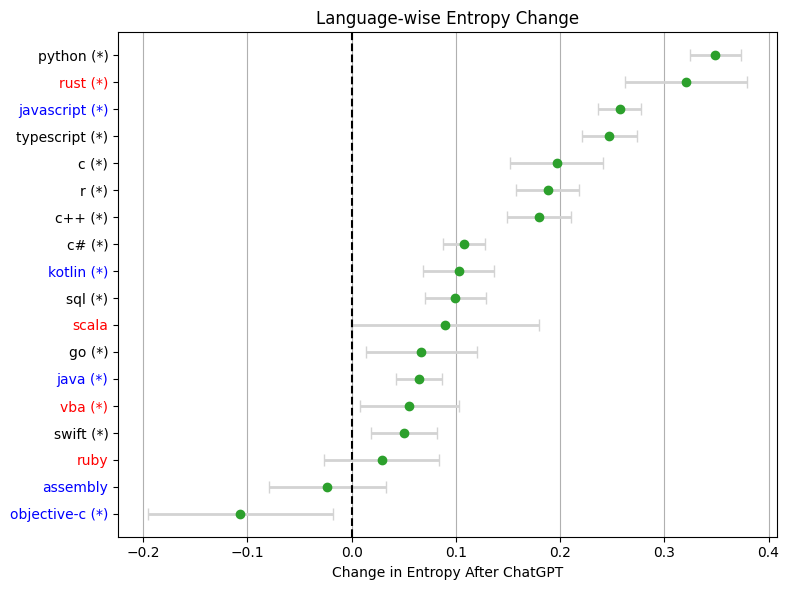

,Language,Mean_Before,Mean_After,Diff,CI_Low,CI_High,pvalue
0,assembly,3.399796,3.376487,-0.023309,-0.079151,0.032534,2.773264e-01
1,c,3.853464,4.050379,0.196914,0.152287,0.241541,1.168540e-11
2,c#,4.354199,4.461986,0.107786,0.087911,0.127662,4.450096e-15
3,c++,4.216737,4.396075,0.179338,0.148693,0.209984,1.225379e-14
4,go,3.478390,3.544969,0.066580,0.013323,0.119837,2.050944e-02
5,java,4.606085,4.670533,0.064448,0.042130,0.086765,3.889071e-08
6,javascript,4.119059,4.376109,0.257050,0.236748,0.277352,1.060355e-18
7,kotlin,3.523366,3.626088,0.102722,0.068649,0.136796,7.429893e-08
8,objective-c,2.721702,2.614971,-0.106730,-0.195422,-0.018038,3.996394e-02
9,python,4.455453,4.804284,0.348831,0.324344,0.373319,1.060355e-18


In [45]:
# (1) 데이터 준비
# data에는 'matched_tags' (언어명), 'period' (before/after), 'entropy' 컬럼이 있어야 해

# (2) 분석
summary_df = analyze_entropy_change(df_entropy_viz, measure='entropy')

plot_forest_with_significance(summary_df)

# (4) Summary 테이블도 확인 가능
display(summary_df)
